## Imports

In [1]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import tensorflow
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as image_utils
from IPython.display import Image
import os
from sklearn.metrics import confusion_matrix

In [2]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tensorflow.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tensorflow.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load Pre-Trained Model

In [3]:
model = tensorflow.keras.applications.VGG16(input_shape=(48, 48, 3),
                                            include_top=False,
                                            weights='imagenet'
                                           )

## Read Data and configure Hyperparameters

In [4]:
# Define data generators
train_dir = 'images/train'
val_dir = 'images/validation'
test_dir = 'images/test'

num_train = 17010 
num_val = 3500
batch_size = 250
num_epoch = 3

# Convert gray pictures in Training Data to rgb
def gray_to_rgb(image):
    image = np.dstack([image] * 1)
    return image

train_datagen = ImageDataGenerator(preprocessing_function=gray_to_rgb, horizontal_flip=True, rescale=1./255)
val_datagen = ImageDataGenerator(preprocessing_function=gray_to_rgb, rescale=1./255)
test_datagen = ImageDataGenerator(preprocessing_function=gray_to_rgb, rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48,48),
        batch_size=batch_size,
        class_mode='categorical')

Found 17010 images belonging to 3 classes.
Found 3500 images belonging to 3 classes.
Found 3500 images belonging to 3 classes.


## Adjust Model to predict 7 classes

In [5]:
keras_input = Input(shape=(48, 48,3), name = 'image_input')

#Use the generated model 
out_model = model(keras_input)

#Add fully-connected layer
x = Flatten(name='flatten')(out_model)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(3, activation='softmax', name='predictions')(x)


model = Model(keras_input, outputs=x)

## Train and save Model

In [6]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)

model.save('model.h5')

D:\Programme\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
68/68 [==============================] - 100s 1s/step - loss: 1.0476 - accuracy: 0.4480 - val_loss: 0.7287 - val_accuracy: 0.6783
Epoch 2/3
68/68 [==============================] - 57s 845ms/step - loss: 0.6949 - accuracy: 0.6841 - val_loss: 0.6806 - val_accuracy: 0.6829
Epoch 3/3
68/68 [==============================] - 69s 1s/step - loss: 0.5814 - accuracy: 0.7455 - val_loss: 0.5883 - val_accuracy: 0.7460


## Plot Training History

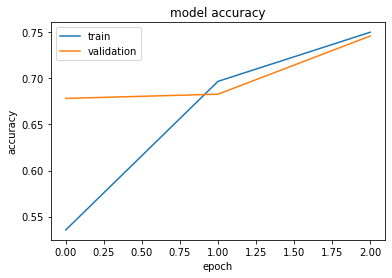

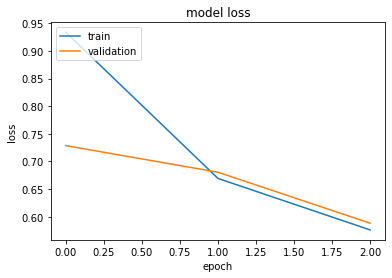

In [7]:
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Model

In [8]:
model = tensorflow.keras.models.load_model('model.h5')

## Use Model to predict images

In [8]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

for file in os.listdir("test/"):
    picture = cv2.imread("test/"+file)
    original = picture
    picture = cv2.resize(picture, (48, 48))
    image = image_utils.img_to_array(picture)
    img_tensor = np.expand_dims(image, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 
    y_prob = model.predict(img_tensor)
    if max(y_prob[0]) > 0.1:
        y_classes = y_prob.argmax(axis=-1)
        label_map = (train_generator.class_indices)
        label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
        predictions = [label_map[k] for k in y_classes]
        cv2.putText(original, predictions[0]+" "+str(round(max(y_prob[0]),3))+"%", (350, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        cv2.imshow("Classification", original)
        cv2.waitKey(0)

## Use Model to predict live with Webcam

In [60]:
camera = cv2.VideoCapture(0)

while True:
    ret, frame = camera.read()
    original = frame
    frame = cv2.resize(frame, (48, 48))
    image = image_utils.img_to_array(frame)
    img_tensor = np.expand_dims(image, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 
    y_prob = model.predict(img_tensor)
    if max(y_prob[0]) > 0.1:
        y_classes = y_prob.argmax(axis=-1)
        label_map = (train_generator.class_indices)
        label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
        predictions = [label_map[k] for k in y_classes]
        cv2.putText(original, predictions[0]+" "+str(round(max(y_prob[0]),3))+"%", (350, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        cv2.imshow("Classification", original)
        cv2.waitKey(0)
            
camera.release()
cv2.destroyAllWindows()    

KeyboardInterrupt: 

## Evaluation of Model

In [11]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Wahren Werte', fontsize=16)
    plt.xlabel('Prognostizierte Werte', fontsize=16)
    plt.show()

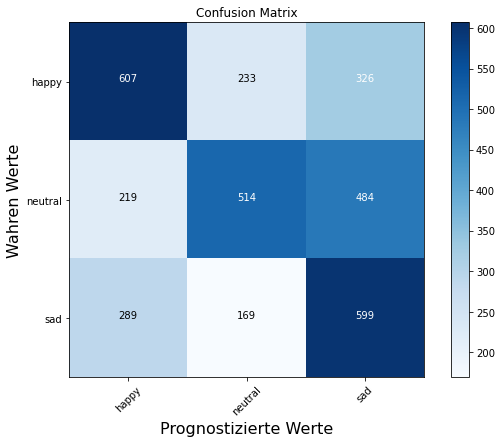

In [41]:
Y_pred = model.predict_generator(test_generator, 3500 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
plot_confusion_matrix(cm = np.array(confusion_matrix(test_generator.classes, y_pred)), 
                      normalize = False,
                      target_names = ['happy', 'neutral', 'sad'],
                      title = "Confusion Matrix")